In [1]:
import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizerFast

# Charger les données depuis le fichier CSV
df = pd.read_csv("data/train_2.csv")

# Mappage des labels textuels en entiers
label_map = {"person": 1, "content": 2}

def map_labels(label_list):
    return [label_map.get(label, 0) for label in label_list]

# Appliquer le mappage des labels
df['words'] = df['words'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['labels'] = df['labels'].apply(lambda x: map_labels(eval(x)) if isinstance(x, str) else x)

# Créer un Dataset Hugging Face
data = Dataset.from_pandas(df)

# Prétraitement des données

In [2]:
# Initialiser le tokeniseur
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Fonction de tokenisation et d'alignement des labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["words"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Appliquer la fonction de tokenisation aux données
tokenized_data = data.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/2931 [00:00<?, ? examples/s]

In [3]:
# Afficher un échantillon des données tokenisées
for i in range(5):  # Sélectionner les 5 premiers échantillons
    print(f"Exemple {i+1}")
    print("Phrase originale:", df.iloc[i]['words'])
    print("Tokens:", tokenizer.convert_ids_to_tokens(tokenized_data[i]["input_ids"]))
    print("Labels:", tokenized_data[i]["labels"])
    print("\n")



Exemple 1
Phrase originale: ['Send', 'a', 'message', 'to', 'Mom', 'telling', 'her', "I'll", 'be', 'home', 'late']
Tokens: ['[CLS]', 'send', 'a', 'message', 'to', 'mom', 'telling', 'her', 'i', "'", 'll', 'be', 'home', 'late', '[SEP]']
Labels: [-100, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, -100]


Exemple 2
Phrase originale: ['Write', 'to', 'the', 'professor', 'asking', 'about', 'the', 'exam', 'format']
Tokens: ['[CLS]', 'write', 'to', 'the', 'professor', 'asking', 'about', 'the', 'exam', 'format', '[SEP]']
Labels: [-100, 0, 0, 1, 1, 0, 2, 2, 2, 2, -100]


Exemple 3
Phrase originale: ['Text', 'John', 'asking', 'if', "he's", 'available', 'for', 'a', 'meeting', 'tomorrow']
Tokens: ['[CLS]', 'text', 'john', 'asking', 'if', 'he', "'", 's', 'available', 'for', 'a', 'meeting', 'tomorrow', '[SEP]']
Labels: [-100, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, -100]


Exemple 4
Phrase originale: ['Message', 'the', 'customer', 'support', 'about', 'my', 'order', 'status']
Tokens: ['[CLS]', 'message', 'the', '

# Model

In [4]:
import tensorflow as tf
from transformers import TFDistilBertForTokenClassification

# Charger le modèle pré-entraîné
model = TFDistilBertForTokenClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=len(label_map) + 1  # +1 pour le label 0
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForTokenClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able t

In [5]:
from transformers import DataCollatorForTokenClassification

# taille maximale des séquences
max_length = 128

# fonction pour aligner et tronquer les séquences
def align_and_truncate(data):
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(
        data['input_ids'], maxlen=max_length, dtype='long', padding='post', truncating='post'
    )
    attention_mask = tf.keras.preprocessing.sequence.pad_sequences(
        data['attention_mask'], maxlen=max_length, dtype='long', padding='post', truncating='post'
    )
    labels = tf.keras.preprocessing.sequence.pad_sequences(
        data['labels'], maxlen=max_length, dtype='long', padding='post', truncating='post', value=-100
    )
    return {'input_ids': input_ids, 'attention_mask': attention_mask}, labels


train_features, train_labels = align_and_truncate(tokenized_data)

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(10000).batch(16)


In [6]:
def custom_loss(y_true, y_pred):
    # Trouver les indices où les labels ne sont pas -100
    active_loss = tf.reshape(y_true, (-1,)) != -100

    # Sélectionner les prédictions et les labels réels pour ces indices
    reduced_logits = tf.boolean_mask(tf.reshape(y_pred, (-1, tf.shape(y_pred)[2])), active_loss)
    reduced_labels = tf.boolean_mask(tf.reshape(y_true, (-1,)), active_loss)

    loss = tf.keras.losses.sparse_categorical_crossentropy(reduced_labels, reduced_logits, from_logits=True)
    return loss


optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, loss=custom_loss)

history = model.fit(train_dataset, epochs=1)


184/184 [==============================] - 430s 2s/step - loss: 0.1396


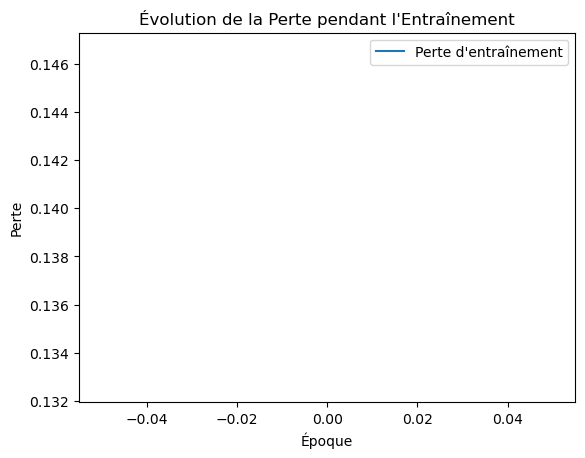

In [7]:
import matplotlib.pyplot as plt

# Tracer l'historique de la perte
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.title('Évolution de la Perte pendant l\'Entraînement')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend()
plt.show()


# EVALUATE


In [8]:
test_df = pd.read_csv("data/test.csv")

# Appliquer le mappage des labels et la tokenisation
test_df['words'] = test_df['words'].apply(lambda x: eval(x) if isinstance(x, str) else x)
test_df['labels'] = test_df['labels'].apply(lambda x: [label_map.get(label, 0) for label in eval(x)] if isinstance(x, str) else x)

test_data = Dataset.from_pandas(test_df)

# Appliquer la tokenisation et l'alignement des labels
tokenized_test_data = test_data.map(tokenize_and_align_labels, batched=True)

test_features, test_labels = align_and_truncate(tokenized_test_data)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

eval_loss = model.evaluate(test_dataset)
print(f"Perte sur l'ensemble de test: {eval_loss}")


Map:   0%|          | 0/1991 [00:00<?, ? examples/s]

125/125 [==============================] - 89s 700ms/step - loss: 0.0532
Perte sur l'ensemble de test: 0.05322042852640152


In [10]:
from seqeval.metrics import classification_report
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != -100:
                out_label_list[i].append(label_map_inv[label_ids[i][j]])
                preds_list[i].append(label_map_inv[preds[i][j]])

    return preds_list, out_label_list


# Mettre à jour le label_map_inv pour inclure tous les labels nécessaires
label_map_inv = {i: label for label, i in label_map.items()}
label_map_inv[0] = "O"  # Ajouter une étiquette pour le label 0


# Ensuite, réexécutez la partie de prédiction et de calcul des métriques
predictions, true_labels = [], []
for batch in test_dataset:
    logits = model.predict(batch[0])['logits']
    labels = batch[1].numpy()
    preds, labels = align_predictions(logits, labels)
    predictions.extend(preds)
    true_labels.extend(labels)

# Calculer les métriques
print(classification_report(true_labels, predictions))



1/1 [==============================] - 0s 449ms/step


D:\Documents\programme\anaconda3\envs\NLP_TD4\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: person seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
D:\Documents\programme\anaconda3\envs\NLP_TD4\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: content seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

       erson       0.81      0.94      0.87       478
      ontent       0.49      0.52      0.51       149

   micro avg       0.74      0.84      0.79       627
   macro avg       0.65      0.73      0.69       627
weighted avg       0.73      0.84      0.78       627


# Predict

In [11]:
def extract_entities(sentence, model, tokenizer, label_map_inv):
    # Tokeniser la phrase
    inputs = tokenizer.encode_plus(sentence, return_tensors='tf', max_length=128, pad_to_max_length=True)

    # Obtenir les prédictions du modèle
    predictions = model.predict({'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']})[0]

    # Obtenir les indices des labels prédits
    predicted_label_indices = tf.argmax(predictions, axis=-1).numpy()[0]

    # Extraire les labels et les tokens correspondants
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].numpy()[0])
    labels = [label_map_inv.get(idx, "O") for idx in predicted_label_indices]

    # Ignorer les tokens spéciaux et les paddings
    tokens_labels = [(token, label) for token, label in zip(tokens, labels) if token not in ["[CLS]", "[SEP]", "[PAD]"]]

    # Extraire les entités
    entities = {"person": [], "content": []}
    for token, label in tokens_labels:
        if label == "person":
            entities["person"].append(token)
        elif label == "content":
            entities["content"].append(token)

    return entities


In [12]:
# Exemple de phrase
test_sentence = "Send a message to John telling him about the meeting tomorrow."

# Extraire les entités
extracted_entities = extract_entities(test_sentence, model, tokenizer, label_map_inv)

# Construire le résultat final
result = {
    "job": "send_message",
    "receiver": " ".join(extracted_entities["person"]),
    "content": " ".join(extracted_entities["content"]),
}

print(result)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
D:\Documents\programme\anaconda3\envs\NLP_TD4\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 181ms/step
{'job': 'send_message', 'receiver': 'john', 'content': 'him about the meeting tomorrow'}


### API

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio
from threading import Thread

# Nécessaire pour exécuter un serveur async dans un notebook
nest_asyncio.apply()

app = FastAPI()

class Sentence(BaseModel):
    test_sentence: str

@app.post("/extract_entities/")
async def extract_entities_api(sentence: Sentence):
    extracted_entities = extract_entities(sentence.test_sentence, model, tokenizer, label_map_inv)
    result = {
        "job": "send_message",
        "receiver": " ".join(extracted_entities["person"]),
        "content": " ".join(extracted_entities["content"]),
    }
    return result


# Fonction pour exécuter le serveur Uvicorn dans un thread à part
def run_api():
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")

In [ ]:
# Démarrer le serveur dans un thread à part pour ne pas bloquer le notebook
thread = Thread(target=run_api)
thread.start()

#pour test http://localhost:8000/docs